In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install pandas==1.4.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 66.8 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
arviz 0.20.0 requires pandas>=1.5.0, but you have pandas 1.4.0 which is incompatible.
bigframes 1.25.0 requires pandas>=1.5.3, but you have pandas 1.4.0 which is incompatible.
cudf-cu12 24.10.1 requires pandas<2.2.3dev0,>=2.0, but you have pandas 1.4.0 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 1.4.0 which is incompatible.
ibis-framework 9.2.0 requires pandas<3,>=1.5.3, but you have pandas 1.4.0 which is incompatible.
mizani 0.13.0 requires pandas>=2.2.0, but you have pandas 1.4.0 which is incompatible.
plotnine 0.14.0 requires pandas>=2.2.0, bu

In [ ]:
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K
from keras.preprocessing import image
from sklearn.metrics import roc_auc_score, roc_curve
from tensorflow.compat.v1.logging import INFO, set_verbosity

random.seed(a=None, version=2)

set_verbosity(INFO)


def get_mean_std_per_batch(image_path, df, H=320, W=320):
    sample_data = []
    for idx, img in enumerate(df.sample(100)["Image"].values):

        sample_data.append(
            np.array(image.load_img(image_path, target_size=(H, W))))

    mean = np.mean(sample_data[0])
    std = np.std(sample_data[0])
    return mean, std


def load_image(img, image_dir, df, preprocess=True, H=320, W=320):
    """Load and preprocess image."""
    img_path = image_dir + img
    mean, std = get_mean_std_per_batch(img_path, df, H=H, W=W)
    x = image.load_img(img_path, target_size=(H, W))
    if preprocess:
        x -= mean
        x /= std
        x = np.expand_dims(x, axis=0)
    return x


def grad_cam(input_model, image, cls, layer_name, H=320, W=320):
    """GradCAM method for visualizing input saliency."""
    y_c = input_model.output[0, cls]
    conv_output = input_model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]

    gradient_function = K.function([input_model.input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)

    # Process CAM
    cam = cv2.resize(cam, (W, H), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    return cam


def compute_gradcam(model, img, image_dir, df, labels, selected_labels,
                    layer_name='bn'):
    preprocessed_input = load_image(img, image_dir, df)
    predictions = model.predict(preprocessed_input)

    print("Loading original image")
    plt.figure(figsize=(15, 10))
    plt.subplot(151)
    plt.title("Original")
    plt.axis('off')
    plt.imshow(load_image(img, image_dir, df, preprocess=False), cmap='gray')

    j = 1
    for i in range(len(labels)):
        if labels[i] in selected_labels:
            print(f"Generating gradcam for class {labels[i]}")
            gradcam = grad_cam(model, preprocessed_input, i, layer_name)
            plt.subplot(151 + j)
            plt.title(f"{labels[i]}: p={predictions[0][i]:.3f}")
            plt.axis('off')
            plt.imshow(load_image(img, image_dir, df, preprocess=False),
                       cmap='gray')
            plt.imshow(gradcam, cmap='jet', alpha=min(0.5, predictions[0][i]))
            j += 1


def get_roc_curve(labels, predicted_vals, generator):
    auc_roc_vals = []
    for i in range(len(labels)):
        try:
            gt = generator.labels[:, i]
            pred = predicted_vals[:, i]
            auc_roc = roc_auc_score(gt, pred)
            auc_roc_vals.append(auc_roc)
            fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
            plt.figure(1, figsize=(10, 10))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(fpr_rf, tpr_rf,
                     label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve')
            plt.legend(loc='best')
        except:
            print(
                f"Error in generating ROC curve for {labels[i]}. "
                f"Dataset lacks enough examples."
            )
    plt.show()
    return auc_roc_vals


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

from tensorflow.keras.models import load_model



In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/training_dataset.csv")
valid_df = pd.read_csv("/content/drive/MyDrive/valid_dataset.csv")

test_df = pd.read_csv("/content/drive/MyDrive/test_dataset.csv")

train_df.head()

,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,PatientId,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,0,0,0,0,0,0,0,0,0,0,0,8270,0,0,0
1,00000001_001.png,1,0,0,0,1,0,0,0,1,0,0,29855,0,0,0
2,00000001_002.png,0,0,0,0,0,0,0,0,0,0,0,1297,1,0,0
3,00000002_000.png,0,0,0,0,0,0,0,0,0,0,0,12359,0,0,0
4,00000003_001.png,0,0,0,0,0,0,0,0,1,0,0,17951,0,0,0


In [ ]:
labels = ['Cardiomegaly',
          'Emphysema',
          'Effusion',
          'Hernia',
          'Infiltration',
          'Mass',
          'Nodule',
          'Atelectasis',
          'Pneumothorax',
          'Pleural_Thickening',
          'Pneumonia',
          'Fibrosis',
          'Edema',
          'Consolidation']

In [ ]:

def check_for_leakage(df1, df2, patient_col):

    df1_patients_unique = set(df1[patient_col].values)
    df2_patients_unique = set(df2[patient_col].values)

    patients_in_both_groups = df1_patients_unique.intersection(df2_patients_unique)

    leakage = len(patients_in_both_groups) > 0

    return leakage

In [ ]:
print("leakage between train and test: {}".format(check_for_leakage(train_df, test_df, 'PatientId')))
print("leakage between valid and test: {}".format(check_for_leakage(valid_df, test_df, 'PatientId')))

leakage between train and test: False
leakage between valid and test: False


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=8, seed=1, target_w=320, target_h=320):
    print("Getting train generator...")
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization=True
    )
    generator = image_generator.flow_from_dataframe(
        dataframe=df,
        directory=image_dir,
        x_col=x_col,
        y_col=y_cols,
        class_mode="raw",
        batch_size=batch_size,
        shuffle=shuffle,
        seed=seed,
        target_size=(target_w, target_h)
    )

    return generator

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=8, seed=1, target_w=320, target_h=320):
    print("Getting train and valid generators...")
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df,
        directory=image_dir,
        x_col=x_col,
        y_col=y_cols,
        class_mode="raw",
        batch_size=sample_size,
        shuffle=True,
        target_size=(target_w, target_h)
    )
    batch = next(iter(raw_train_generator))
    data_sample = batch[0]
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True
    )
    image_generator.fit(data_sample)
    valid_generator = image_generator.flow_from_dataframe(
        dataframe=valid_df,
        directory=image_dir,
        x_col=x_col,
        y_col=y_cols,
        class_mode="raw",
        batch_size=batch_size,
        shuffle=False,
        seed=seed,
        target_size=(target_w, target_h)
    )

    test_generator = image_generator.flow_from_dataframe(
        dataframe=test_df,
        directory=image_dir,
        x_col=x_col,
        y_col=y_cols,
        class_mode="raw",
        batch_size=batch_size,
        shuffle=False,
        seed=seed,
        target_size=(target_w, target_h)
    )

    return valid_generator, test_generator


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
IMAGE_DIR = "/content/drive/MyDrive/final_images"
train_generator = get_train_generator(train_df, IMAGE_DIR, "Image", labels)
valid_generator, test_generator = get_test_and_valid_generator(valid_df, test_df, train_df, IMAGE_DIR, "Image", labels)


Getting train generator...
Found 956 validated image filenames.
Getting train and valid generators...
Found 956 validated image filenames.


/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 25 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 25 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  warnings.warn(


Found 0 validated image filenames.
Found 5 validated image filenames.


/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 200 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 415 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  warnings.warn(


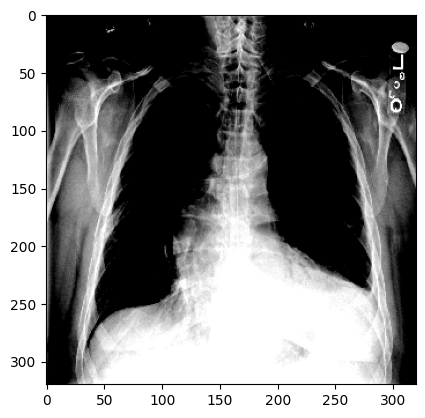

In [ ]:
x,y = train_generator.__getitem__(0)
plt.imshow(x[0])

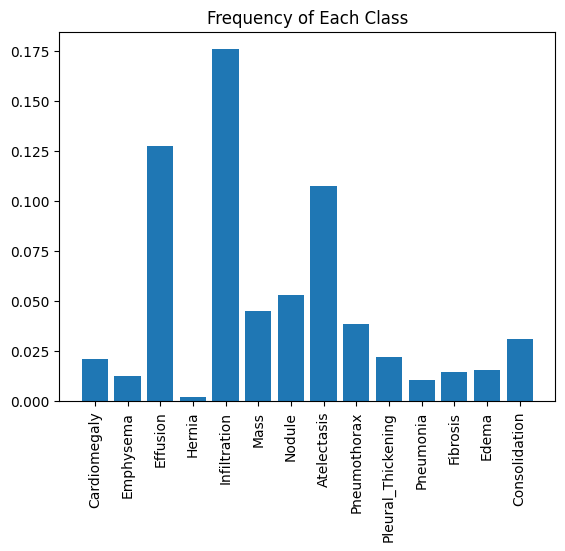

In [ ]:
plt.xticks(rotation=90)
plt.bar(x=labels, height=np.mean(train_generator.labels, axis=0))
plt.title("Frequency of Each Class")
plt.show()

In [ ]:
def compute_class_freqs(labels):
    N = labels.shape[0]

    positive_frequencies = np.sum(labels, axis=0) / N
    negative_frequencies = 1 - positive_frequencies

    return positive_frequencies, negative_frequencies

In [ ]:
import numpy as np
labels_matrix = np.array(
    [[1, 0, 0],
     [0, 1, 1],
     [1, 0, 1],
     [1, 1, 1],
     [1, 0, 1]]
)

print("labels")
print(labels_matrix)
test_pos_freqs, test_neg_freqs = compute_class_freqs(labels_matrix)
print(f"fpos freqs: {test_pos_freqs}")
print(f"fneg freqs: {test_neg_freqs}")


labels
[[1 0 0]
 [0 1 1]
 [1 0 1]
 [1 1 1]
 [1 0 1]]
fpos freqs: [0.8 0.4 0.8]
fneg freqs: [0.2 0.6 0.2]


In [ ]:
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)
freq_pos

array([0.0209205 , 0.0125523 , 0.12761506, 0.00209205, 0.17573222,
       0.04497908, 0.05334728, 0.10774059, 0.03870293, 0.02196653,
       0.01046025, 0.01464435, 0.01569038, 0.03138075])

<ipython-input-18-5144b4a21050>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)


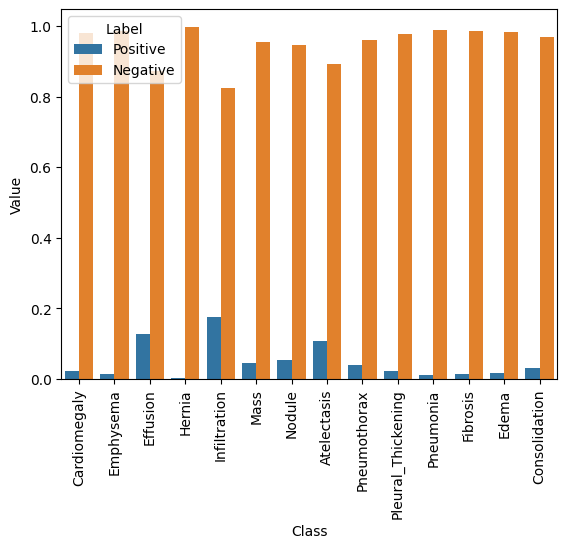

In [ ]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

In [ ]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights
neg_contribution = freq_neg * neg_weights

In [ ]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    def weighted_loss(y_true, y_pred):
        loss = 0.0
        for i in range(len(pos_weights)):
            loss_pos = -1 * K.mean(pos_weights[i] * y_true[:, i] * K.log(y_pred[:, i] + epsilon))
            loss_neg = -1 * K.mean(neg_weights[i] * (1 - y_true[:, i]) * K.log(1 - y_pred[:, i] + epsilon))
            loss += loss_pos + loss_neg

        return loss
    return weighted_loss

In [ ]:

base_model = DenseNet121(weights='/content/drive/MyDrive/densenet.hdf5', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(len(labels), activation="sigmoid")(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss=get_weighted_loss(pos_weights, neg_weights))

In [ ]:
model.load_weights("/content/drive/MyDrive/pretrained_model.h5")

<ipython-input-23-978a3fae5356>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v}


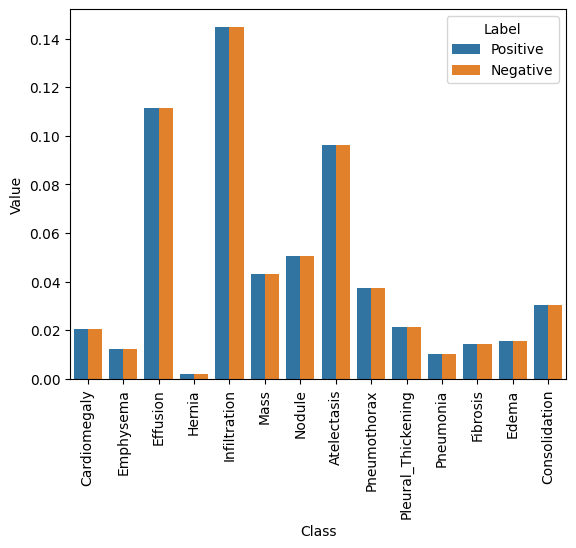

In [ ]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v}
                        for l,v in enumerate(neg_contribution)], ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);

In [ ]:

predicted_vals = model.predict(test_generator, steps=len(test_generator))
print(predicted_vals)


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
[[0.07533049 0.271619   0.12653455 0.51880145 0.3401673  0.14293943
  0.25169724 0.2031037  0.1913917  0.3131502  0.19113387 0.3851727
  0.03913372 0.14154065]
 [0.9659713  0.15310952 0.40886202 0.7880969  0.44936672 0.1864723
  0.27936777 0.43501574 0.11080919 0.37047803 0.37978667 0.40898305
  0.12467968 0.29874456]
 [0.02205688 0.10151204 0.08928405 0.4953276  0.38873312 0.21627943
  0.26759112 0.21823698 0.13130502 0.21077047 0.3012513  0.2958671
  0.01928835 0.18660909]
 [0.00797652 0.4754502  0.58533496 0.37148255 0.26815134 0.23095223
  0.6035437  0.17600012 0.88913035 0.83710647 0.30655107 0.9148013
  0.28424704 0.25617293]
 [0.00857821 0.8610792  0.2761477  0.56708896 0.2808863  0.41445038
  0.6364903  0.34260848 0.869239   0.90193886 0.26207888 0.91892135
  0.1828157  0.24659504]]


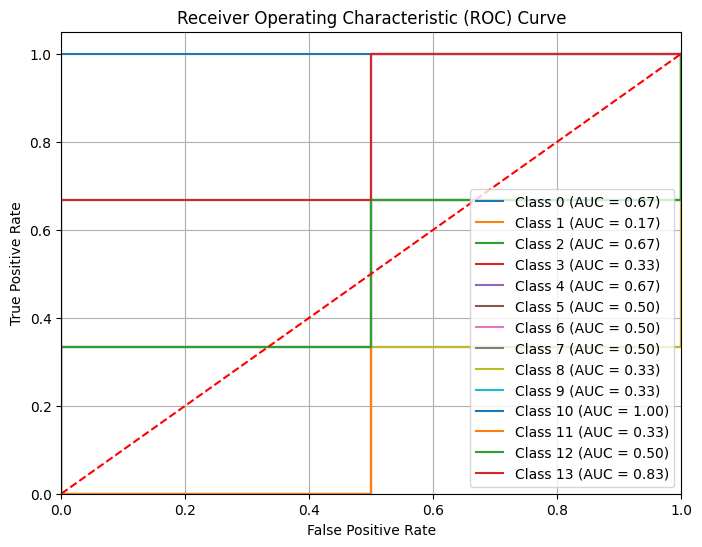

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
y_true = np.array([0, 1, 1, 1, 0])
y_scores = np.array([
    [0.07344599, 0.29353803, 0.130573, 0.53197896, 0.33403033, 0.1454889, 0.2548046, 0.20489655, 0.19503954, 0.3289459, 0.19021638, 0.40292874, 0.04130463, 0.13951597],
    [0.9678397, 0.15724884, 0.41328457, 0.79019684, 0.4467016, 0.18314952, 0.27920887, 0.43601882, 0.1115564, 0.37404907, 0.38002163, 0.41649318, 0.13027361, 0.296455],
    [0.02239269, 0.10432077, 0.08831651, 0.49464005, 0.38950983, 0.21726586, 0.26655063, 0.2182585, 0.13399088, 0.21170017, 0.30053648, 0.29581302, 0.01958583, 0.18712968],
    [0.00822375, 0.47698033, 0.5869775, 0.37544617, 0.2686832, 0.22983575, 0.5991492, 0.17940511, 0.8882072, 0.83679175, 0.30724138, 0.9136799, 0.28988957, 0.2576242],
    [0.00817462, 0.86308527, 0.27339703, 0.57513314, 0.27338344, 0.4139137, 0.6335377, 0.3470301, 0.86674374, 0.9024727, 0.25735998, 0.91964424, 0.1817803, 0.24139361]
])
roc_auc = []
fpr_list = []
tpr_list = []

for i in range(y_scores.shape[1]):
    fpr, tpr, _ = roc_curve(y_true, y_scores[:, i])
    roc_auc_score_value = roc_auc_score(y_true, y_scores[:, i])
    roc_auc.append(roc_auc_score_value)
    fpr_list.append(fpr)
    tpr_list.append(tpr)

plt.figure(figsize=(8, 6))
for i in range(len(roc_auc)):
    plt.plot(fpr_list[i], tpr_list[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
df = pd.read_csv("/content/drive/MyDrive/training_dataset.csv")
IMAGE_DIR = "/content/drive/MyDrive/final_images"

y_true = np.array([0, 1, 1, 1, 0])
y_scores = np.random.rand(5, 4)
auc_rocs = []
for i in range(y_scores.shape[1]):
    auc = roc_auc_score(y_true, y_scores[:, i])
    auc_rocs.append(auc)
labels = np.array(['Emphysema', 'Consolidation', 'Cardiomegaly ', 'Atelectasis'])
labels_to_show = np.take(labels, np.argsort(auc_rocs)[::-1])[:4]
print("Top 4 labels based on AUC:", labels_to_show)


Top 4 labels based on AUC: ['Cardiomegaly ' 'Atelectasis' 'Emphysema' 'Consolidation']


In [ ]:
from tensorflow.keras import backend as K


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Loading original image
Generating gradcam for class Emphysema
Generating gradcam for class Consolidation
Generating gradcam for class Cardiomegaly 
Generating gradcam for class Atelectasis


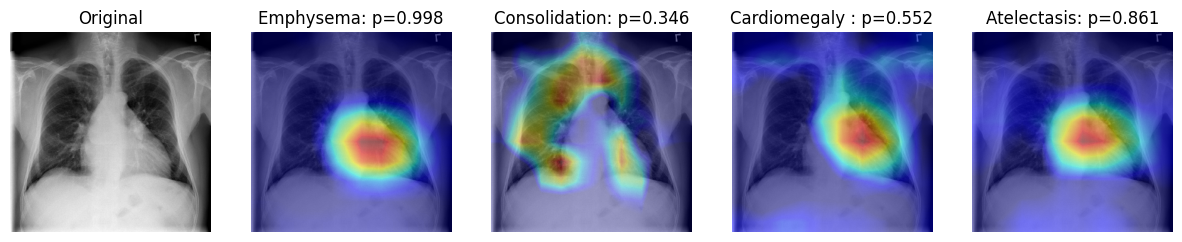

In [ ]:
import random
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K
from keras.preprocessing import image
from sklearn.metrics import roc_auc_score, roc_curve
from tensorflow.compat.v1.logging import INFO, set_verbosity
df = pd.read_csv("/content/drive/MyDrive/training_dataset.csv")
IMAGE_DIR = "/content/drive/MyDrive/final_images/"
random.seed(a=None, version=2)

set_verbosity(INFO)


def get_mean_std_per_batch(image_path, df, H=320, W=320):
    sample_data = []
    for idx, img in enumerate(df.sample(100)["Image"].values):
        # path = image_dir + img
        sample_data.append(
            np.array(image.load_img(image_path, target_size=(H, W))))

    mean = np.mean(sample_data[0])
    std = np.std(sample_data[0])
    return mean, std


def load_image(img, image_dir, df, preprocess=True, H=320, W=320):
    """Load and preprocess image."""
    img_path = image_dir + img
    mean, std = get_mean_std_per_batch(img_path, df, H=H, W=W)
    x = image.load_img(img_path, target_size=(H, W))
    if preprocess:
        x -= mean
        x /= std
        x = np.expand_dims(x, axis=0)
    return x


def grad_cam(input_model, image, cls, layer_name, H=320, W=320):

    layer_output = input_model.get_layer(layer_name).output
    grad_model = tf.keras.Model(inputs=input_model.input, outputs=[layer_output, input_model.output])

    with tf.GradientTape() as tape:
        conv_output, preds = grad_model(image)
        y_c = preds[0, cls]


    grads = tape.gradient(y_c, conv_output)


    grads_val = grads.numpy()[0]
    output = conv_output.numpy()[0]

    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)

    cam = cv2.resize(cam, (W, H), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    return cam




def compute_gradcam(model, img, image_dir, df, labels, selected_labels,
                    layer_name='bn'):
    preprocessed_input = load_image(img, image_dir, df)
    predictions = model.predict(preprocessed_input)

    print("Loading original image")
    plt.figure(figsize=(15, 10))
    plt.subplot(151)
    plt.title("Original")
    plt.axis('off')
    plt.imshow(load_image(img, image_dir, df, preprocess=False), cmap='gray')

    j = 1
    for i in range(len(labels)):
        if labels[i] in selected_labels:
            print(f"Generating gradcam for class {labels[i]}")
            gradcam = grad_cam(model, preprocessed_input, i, layer_name)
            plt.subplot(151 + j)
            plt.title(f"{labels[i]}: p={predictions[0][i]:.3f}")
            plt.axis('off')
            plt.imshow(load_image(img, image_dir, df, preprocess=False),
                       cmap='gray')
            plt.imshow(gradcam, cmap='jet', alpha=min(0.5, predictions[0][i]))
            j += 1


def get_roc_curve(labels, predicted_vals, generator):
    auc_roc_vals = []
    for i in range(len(labels)):
        try:
            gt = generator.labels[:, i]
            pred = predicted_vals[:, i]
            auc_roc = roc_auc_score(gt, pred)
            auc_roc_vals.append(auc_roc)
            fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
            plt.figure(1, figsize=(10, 10))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(fpr_rf, tpr_rf,
                     label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve')
            plt.legend(loc='best')
        except:
            print(
                f"Error in generating ROC curve for {labels[i]}. "
                f"Dataset lacks enough examples."
            )
    plt.show()
    return auc_roc_vals
compute_gradcam(model, '00000001_000.png', IMAGE_DIR, df, labels, labels_to_show)